In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
#Import TensorFlow
import tensorflow as tf
import tensorflow_probability as tfp
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import pickle
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.optimizers import Adam
MultivariateNormalDiag = tfp.distributions.MultivariateNormalDiag
from sklearn.preprocessing import StandardScaler
from google.colab import drive, files
from sklearn.metrics import mean_squared_error
drive.mount('/content/gdrive')

2.8.0
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
###########################################
#MNIST Example
###########################################
#Load in the data
mnist= tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test)=mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0
x_train = x_train.reshape(60000, 784)
scaler = StandardScaler() #Initialize the standardscaler
scaler.fit(x_train)  #Fit the standard scaler
x_train_scaled = scaler.transform(x_train) #Scale the data

In [ ]:
#Fit the VAE for the selected number of hidden nodes
in_size = 784
hid_size = 0.5*in_size
i=2
dense_1 = Dense(hid_size,activation="relu")
dense_2 = Dense(i)  #For the final encoder layer, activation is linear
dense_3 = Dense(i)
dense_4 = Dense(hid_size, activation="relu")
dense_5 = Dense(in_size)

#Encoder
X = Input(shape=(in_size,))
encode_1 = dense_1(X)
encode_2 = dense_2(encode_1)
encode_3 = dense_3(encode_1)

#we can get sigma (standard dev) > 0 from an unbounded variable by passing it through the softplus function. Add a small amount for smoothing.
means = encode_2[:,:i]
stddev = tf.nn.softplus(encode_3[:,:i]) + 1e-6

#Tensorflow random sampling
xi = MultivariateNormalDiag(loc=tf.zeros([i,]),scale_diag=tf.ones([i,])).sample()
Z = means + stddev * xi

#Decoder
decode_1 = dense_4(Z)
decode_2 = dense_5(decode_1)

outputs = tf.concat([decode_2, means, stddev],axis=1)
    
def loss(y_true,y_pred):
  decode = y_pred[:,:in_size]
  means = y_pred[:,in_size:in_size+i]
  stddev = y_pred[:,in_size+i:in_size+i*2]
  expected_log_likelihood = -tf.reduce_sum(tf.square(decode-y_true),1)
  kl = tf.reduce_sum(-tf.math.log(stddev) + 0.5*(tf.square(stddev)+ tf.square(means))-0.5, axis=1)
  elbo = tf.reduce_sum(expected_log_likelihood-kl)
  return -elbo

VAE = Model(inputs=X,outputs=outputs)
VAE.compile(loss=loss, optimizer='adam')  # Compile the combined model

In [ ]:
r=VAE.fit(x_train_scaled,x_train_scaled,epochs=30,batch_size=32,shuffle=True)

In [ ]:
#Create decoder model
encoded_input = Input(shape=(2,))
decode_1 = dense_4(encoded_input)
decode_2 = dense_5(decode_1)
decoder = Model(inputs=encoded_input,outputs=decode_2)

In [ ]:
#Plot what image is reproduced for different parts of Z
n = 19 # number of images per side
x_values = np.linspace(-3,3,n)
y_values = np.linspace(-3,3,n)
image = np.empty((28*n,28*n))

#build Z first so we don't have to keep re-calling the predict function
Z2 = []
for i, x in enumerate(x_values):
  for j, y in enumerate(y_values):
    z = [x,y]
    Z2.append(z)
X_recon = scaler.inverse_transform(decoder.predict(Z2))

k = 0
for i, x in enumerate(x_values):
  for j, y in enumerate(y_values):
    x_recon = X_recon[k]
    k += 1
    #convert from NxD == 1 x 784 --> 28 x 28
    x_recon = x_recon.reshape(28, 28)
    image[(n-i-1)*28:(n-i)*28, j*28:(j+1)*28] = (x_recon > 0.4)

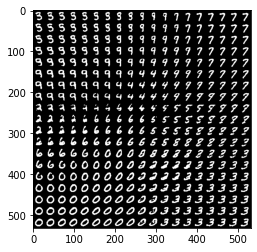

In [ ]:
plt.imshow(image, cmap='gray')

In [ ]:
##########################################################################################
#Train the VAE using Plaxis simulated embankment responses
##########################################################################################

#Load the data
M0 = np.array(pd.read_csv('/content/gdrive/My Drive/M0_simulated.csv',header=None))
M1 = np.array(pd.read_csv('/content/gdrive/My Drive/M1_simulated.csv',header=None))
M2 = np.array(pd.read_csv('/content/gdrive/My Drive/M2_simulated.csv',header=None))
M3 = np.array(pd.read_csv('/content/gdrive/My Drive/M3_simulated.csv',header=None))
HPG1_1 = np.array(pd.read_csv('/content/gdrive/My Drive/HPG1_1_simulated.csv',header=None))
HPG1_2 = np.array(pd.read_csv('/content/gdrive/My Drive/HPG1_2_simulated.csv',header=None))
HPG1_3 = np.array(pd.read_csv('/content/gdrive/My Drive/HPG1_3_simulated.csv',header=None))
VWP6b = np.array(pd.read_csv('/content/gdrive/My Drive/VWP6b_ex_simulated.csv',header=None))
VWP6c = np.array(pd.read_csv('/content/gdrive/My Drive/VWP6c_ex_simulated.csv',header=None))

x_data = np.vstack((M0,M1,M2,M3,HPG1_1,HPG1_2,HPG1_3,VWP6b,VWP6c)).T
print("x_data.shape:",x_data.shape)

#Scale the data using standardscalar
scaler = StandardScaler() #Initialize the standardscaler
scaler.fit(x_data)  #Fit the standard scaler
x_data_scaled = scaler.transform(x_data) #Scale the data
with open(f'scaler.pkl', 'wb') as f:
  pickle.dump(scaler, f)  #Save the standard scalar

x_data.shape: (300, 1170)


In [ ]:
#Reconstruction error against number of latent nodes
reconstruct_err = np.zeros(10)
for i in range (1,11):
  in_size = 1170 #Size of input layer
  hid_size = 0.5*in_size  #Size of hidden layer
  dense_1 = Dense(hid_size,activation="relu")
  dense_2 = Dense(i)
  dense_3 = Dense(i)
  dense_4 = Dense(hid_size, activation="relu")
  dense_5 = Dense(in_size)

  #encoder
  X = Input(shape=(in_size,))
  encode_1 = dense_1(X)
  encode_2 = dense_2(encode_1)
  encode_3 = dense_3(encode_1)

  means = encode_2[:,:i]
  stddev = tf.nn.softplus(encode_3[:,:i]) + 1e-6

  xi = MultivariateNormalDiag(loc=tf.zeros([i,]),scale_diag=tf.ones([i,])).sample()
  Z = means + stddev * xi

  #Decoder 
  decode_1 = dense_4(Z)
  decode_2 = dense_5(decode_1)

  outputs = tf.concat([decode_2, means, stddev],axis=1)

  def loss(y_true,y_pred):
    decode = y_pred[:,:in_size]
    means = y_pred[:,in_size:in_size+i]
    stddev = y_pred[:,in_size+i:in_size+i*2]
    expected_log_likelihood = -tf.reduce_sum(tf.square(decode-y_true),1)
    kl = tf.reduce_sum(-tf.math.log(stddev) + 0.5*(tf.square(stddev)+ tf.square(means))-0.5, axis=1)
    elbo = tf.reduce_sum(expected_log_likelihood-kl)
    return -elbo

  VAE = Model(inputs=X,outputs=outputs)
  VAE.compile(loss=loss, optimizer='adam')  # Compile the combined model

  r=VAE.fit(x_data_scaled,x_data_scaled,epochs=1000,batch_size=32,shuffle=True)

  #Evalute reconstruction error
  reconstructed_data = VAE.predict(x_data_scaled)[:,:in_size]
  reconstruct_err[i-1]= mean_squared_error(x_data_scaled,reconstructed_data[:,:in_size])

串流輸出內容已截斷至最後 5000 行。
Epoch 501/1000
10/10 [==============================] - 0s 4ms/step - loss: 782.4054
Epoch 502/1000
10/10 [==============================] - 0s 4ms/step - loss: 753.0625
Epoch 503/1000
10/10 [==============================] - 0s 4ms/step - loss: 727.6721
Epoch 504/1000
10/10 [==============================] - 0s 4ms/step - loss: 735.5627
Epoch 505/1000
10/10 [==============================] - 0s 5ms/step - loss: 734.5968
Epoch 506/1000
10/10 [==============================] - 0s 4ms/step - loss: 724.4308
Epoch 507/1000
10/10 [==============================] - 0s 4ms/step - loss: 752.9377
Epoch 508/1000
10/10 [==============================] - 0s 4ms/step - loss: 743.1047
Epoch 509/1000
10/10 [==============================] - 0s 5ms/step - loss: 738.9824
Epoch 510/1000
10/10 [==============================] - 0s 4ms/step - loss: 756.6401
Epoch 511/1000
10/10 [==============================] - 0s 4ms/step - loss: 730.5751
Epoch 512/1000
10/10 [======================

[0.22576971 0.06160438 0.01891629 0.00857433 0.00593392 0.00421138
 0.00489568 0.00410338 0.00473573 0.00550428]


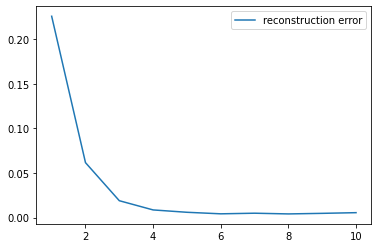

In [ ]:
print(reconstruct_err)
plt.plot(range(1,11),reconstruct_err,label='reconstruction error')
plt.legend()

In [ ]:
#Fit VAE again using the selected number of latent nodes
in_size = 1170  #Size of input layer
hid_size = 0.5*in_size  #Size of hidden layer
i=6
dense_1 = Dense(hid_size,activation="relu")
dense_2 = Dense(i) 
dense_3 = Dense(i)
dense_4 = Dense(hid_size, activation="relu")
dense_5 = Dense(in_size)

#encoder
X = Input(shape=(in_size,))
encode_1 = dense_1(X)
encode_2 = dense_2(encode_1)
encode_3 = dense_3(encode_1)

means = encode_2[:,:i]
stddev = tf.nn.softplus(encode_3[:,:i]) + 1e-6

xi = MultivariateNormalDiag(loc=tf.zeros([i,]),scale_diag=tf.ones([i,])).sample()
Z = means + stddev * xi

#Decoder
decode_1 = dense_4(Z)
decode_2 = dense_5(decode_1)

outputs = tf.concat([decode_2, means, stddev],axis=1)
    
def loss(y_true,y_pred):
  decode = y_pred[:,:in_size]
  means = y_pred[:,in_size:in_size+i]
  stddev = y_pred[:,in_size+i:in_size+i*2]
  expected_log_likelihood = -tf.reduce_sum(tf.square(decode-y_true),1)
  kl = tf.reduce_sum(-tf.math.log(stddev) + 0.5*(tf.square(stddev)+ tf.square(means))-0.5, axis=1)
  elbo = tf.reduce_sum(expected_log_likelihood-kl)
  return -elbo

VAE = Model(inputs=X,outputs=outputs)
VAE.compile(loss=loss, optimizer='adam')  # Compile the combined model

In [ ]:
r=VAE.fit(x_data_scaled,x_data_scaled,epochs=5000,batch_size=32,shuffle=True)

Epoch 1/5000
10/10 [==============================] - 1s 6ms/step - loss: 29879.9805
Epoch 2/5000
10/10 [==============================] - 0s 5ms/step - loss: 8901.0186
Epoch 3/5000
10/10 [==============================] - 0s 5ms/step - loss: 8072.8252
Epoch 4/5000
10/10 [==============================] - 0s 5ms/step - loss: 6390.1934
Epoch 5/5000
10/10 [==============================] - 0s 5ms/step - loss: 4844.5781
Epoch 6/5000
10/10 [==============================] - 0s 7ms/step - loss: 3896.3008
Epoch 7/5000
10/10 [==============================] - 0s 5ms/step - loss: 4622.9893
Epoch 8/5000
10/10 [==============================] - 0s 5ms/step - loss: 4467.8521
Epoch 9/5000
10/10 [==============================] - 0s 5ms/step - loss: 3246.0393
Epoch 10/5000
10/10 [==============================] - 0s 5ms/step - loss: 2875.6226
Epoch 11/5000
10/10 [==============================] - 0s 5ms/step - loss: 2461.1179
Epoch 12/5000
10/10 [==============================] - 0s 6ms/step - loss

KeyboardInterrupt: ignored

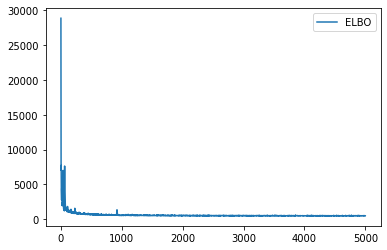

In [ ]:
plt.plot(r.history['loss'], label = 'ELBO')
plt.legend()

In [ ]:
pd.DataFrame(r.history['loss']).to_csv('/content/gdrive/My Drive/ELBO.csv', index=False, header=False) #Save the ELBO during training

In [ ]:
#Create and save the encoder model
encoder = Model(inputs=X,outputs=means)
encoder.save_weights('/content/gdrive/My Drive/encoder_vae.h5') #Save the weights of the encoder
post_sd_network = Model(inputs=X,outputs=stddev)
post_sd_network.save_weights('/content/gdrive/My Drive/post_sd_vae.h5') #Save the weights of the SD network

In [ ]:
#Create and save the decoder model
encoded_input = Input(shape=(6,)) #Change this line to match the size of latent space
decode_1 = dense_4(encoded_input)
decode_2 = dense_5(decode_1)
decoder = Model(inputs=encoded_input,outputs=decode_2)
decoder.save_weights('/content/gdrive/My Drive/decoder_vae.h5') #Save the weights of the decoder